In [1]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sat(N, orbit_radius_km):
    # orbital radius = 6378 km (Earth radius) + altitude
    # max altitude = geostationary orbit ~35786 km
    sat_theta = np.random.uniform(0, 2 * np.pi, N) #azimuthal angle
    # sat_phi = np.random.uniform(0, np.pi, N) #Talk about why this is wrong in report
    sat_phi = np.arccos(1 - 2 * np.random.uniform(0, 1, N)) # to ensure uniform distribution on sphere // polar angle

    sat_x = orbit_radius_km * np.sin(sat_phi) * np.cos(sat_theta)
    sat_y = orbit_radius_km * np.sin(sat_phi) * np.sin(sat_theta)
    sat_z = orbit_radius_km * np.cos(sat_phi)

    sat = np.array([sat_x, sat_y, sat_z]).T

    return sat


In [3]:
def earth(earth_radius_km, params=None):
    #specify spherical coordinates
    earth_theta = np.linspace(0, 2 * np.pi, 100)  # azimuthal angle
    earth_phi = np.linspace(0, np.pi, 100)        # polar angle
    earth_theta, earth_phi = np.meshgrid(earth_theta, earth_phi)
    
    # Unit vectors on sphere surface
    earth_x = np.sin(earth_phi) * np.cos(earth_theta)  # UNIT vectors!
    earth_y = np.sin(earth_phi) * np.sin(earth_theta)
    earth_z = np.cos(earth_phi)

    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(111, projection='3d')
    #ax.plot_surface(earth_x, earth_y, earth_z, color='b', alpha=0.5)
    
    earth_mesh = np.stack([earth_x, earth_y, earth_z], axis=-1) * earth_radius_km
    
    if params is None:
        weights = np.ones(earth_x.shape)
        return earth_mesh, weights
    
    else:
        weights = np.zeros(earth_x.shape)
        
        for p in params:
            lat, lon, strength, size = p  # lat = 0 to 90, lon = -180 to 180, strength = whatever, size = radians 
            
            lat_rad = np.radians(90 - lat) 
            lon_rad = np.radians(lon)
            
            gauss_x = np.sin(lat_rad) * np.cos(lon_rad)  
            gauss_y = np.sin(lat_rad) * np.sin(lon_rad)  
            gauss_z = np.cos(lat_rad)                    

            dot = earth_x * gauss_x + earth_y * gauss_y + earth_z * gauss_z
            
            rows, cols = dot.shape
            for i in range(rows): # avoid numerical errors with arccos
                for j in range(cols):
                    if dot[i,j] > 1.0:
                        dot[i,j] = 1.0
                    elif dot[i,j] < -1.0:
                        dot[i,j] = -1.0
            
            # angular distance in radians // see dist function
            angular_dist = np.arccos(dot)
            
            land = strength * np.exp(-angular_dist**2 / (2 * size**2)) # from hw 7 
            weights += land
        
        weights += 0.1  # oceans 

        
        return earth_mesh, weights

In [4]:
def lloyd3D(robots, X, Y, Z, W, weights, orbital_rad, k=0.1):
    new = []

    for i in range(len(robots)):
        test = (W == i)
        if np.sum(test) == 0:
            new.append(robots[i])
            continue

        weight = weights[test]
        
        x_mean = np.sum(X[test] * weight) / np.sum(weight) # calculate centroid with weights now
        y_mean = np.sum(Y[test] * weight) / np.sum(weight)
        z_mean = np.sum(Z[test] * weight) / np.sum(weight)

        newX = robots[i][0] - k * (robots[i][0] - x_mean) # move towards centroid
        newY = robots[i][1] - k * (robots[i][1] - y_mean)
        newZ = robots[i][2] - k * (robots[i][2] - z_mean)

        direction = np.array([newX, newY, newZ])
        mag = np.linalg.norm(direction)
        projected  = direction * orbital_rad/ mag  # normalize
        new.append([projected[0], projected[1], projected[2]])
    return np.array(new)

In [5]:
@jit(nopython=True)  # to speed up
def dist(X,Y,Z, robots): # note this is not  euclidean distance but angular distance on a sphere
    W = np.zeros(X.shape)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
                earth = np.array([X[i,j], Y[i,j], Z[i,j]])
                earth_norm = np.sqrt(earth[0]**2 + earth[1]**2 + earth[2]**2) # numba is picky with np.linalg.norm so we will use this instead
                xearth = earth[0] / earth_norm  # normalize to unit vector
                yearth = earth[1] / earth_norm  
                zearth = earth[2] / earth_norm

                ang = []

                for robot in robots:
                    robot_norm = np.sqrt(robot[0]**2 + robot[1]**2 + robot[2]**2) # numba is picky with np.linalg.norm so we will use this instead
                    xrobot = robot[0] / robot_norm  # normalize to unit vector
                    yrobot = robot[1] / robot_norm  
                    zrobot = robot[2] / robot_norm

                    dot = xearth * xrobot + yearth * yrobot + zearth * zrobot

                    if dot > 1.0: # to prevent numerical errors with arccos
                        dot = 1.0

                    if dot < -1.0: 
                        dot = -1.0

                    angle = np.arccos(dot) 
                    ang.append(angle)

                temp2 = np.array(ang)
                W[i,j] = np.argmin(temp2)
    
    return W
        

In [6]:
def trajectory(start, target, altitude):
    traj = []
    
    # Normalize
    u = start / np.linalg.norm(start)
    v = target / np.linalg.norm(target)
    
    # Slerp angle
    dot = np.dot(u, v)

    if dot > 1.0: # to prevent numerical errors with arccos
        dot = 1.0
    if dot < -1.0:
        dot = -1.0

    angle = np.arccos(dot)
    
    for t in range(100):
        t = t/100
        # slerp equation
        interpolated = (np.sin((1-t)*angle)*u + np.sin(t*angle)*v) / np.sin(angle)
        traj.append(interpolated * altitude)
    
    return np.array(traj)

In [7]:
def sim(N, alt, tf, dt, k, tol=1e-6):
    earth_radius_km = 6370
    orbital_rad = earth_radius_km + alt
    
    # gaussians / land masses settings, lat (0 to 90), lon (-180 to 180), strength, size (radians)
    params = [    
        [45, -10, 25, 0.2], 
        [45, -110, 50, 0.1], 
    ]
    
    earth_mesh, weights = earth(earth_radius_km, params)
    earth_X, earth_Y, earth_Z = earth_mesh[:,:,0], earth_mesh[:,:,1], earth_mesh[:,:,2]
    

    ###################################################
    
    # heatmap
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.cm.hot(weights)
    ax.plot_surface(earth_X, earth_Y, earth_Z, facecolors=colors)
    ax.set_title('Gaussians/Land Masses on Earth Surface')
    plt.show()


    ###################################################
    
    agents = sat(N, orbital_rad)

    tvals = int(tf/dt) + 1
    t = np.linspace(0, tf, tvals)

    positions = [agents.copy()] # store robot positions over time

    ###################################################
    
    for step, time in enumerate(t): 
        W = dist(earth_X, earth_Y, earth_Z, agents)

        agents = lloyd3D(agents, earth_X, earth_Y, earth_Z, W, weights, orbital_rad, k) #run Lloyd's algorithm to update positions
        positions.append(agents.copy())

        delta = np.linalg.norm(np.array(positions[-1]) - np.array(positions[-2])) # measure of change 

        if step == 0 or step == len(t)-1 or delta < tol:
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection='3d')
            
            # Color the Earth surface with Voronoi regions
            colors = plt.cm.nipy_spectral(W/len(agents)) 
            surf = ax.plot_surface(earth_X, earth_Y, earth_Z, facecolors=colors, alpha=1)
            
            for i, agent in enumerate(agents):
                # Get the color for this satellite's region
                satellite_color = plt.cm.nipy_spectral(i/len(agents))
                ax.scatter(agent[0], agent[1], agent[2], color=satellite_color, edgecolor='k', s=100) #label=f'Satellite {i+1}')

            ax.set_title(f'Satellite Coverage using 3D Voronoi + Lloyd\'s Algorithm (N={len(agents)}, step={step})')
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Y (km)')
            ax.set_zlabel('Z (km)')
            ax.axis('equal')
            ax.set_xlim([-orbital_rad*2, orbital_rad*2])
            ax.set_ylim([-orbital_rad*2, orbital_rad*2])
            ax.set_zlim([-orbital_rad*2, orbital_rad*2])
            #ax.legend()
            plt.show()


            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection='3d')
            ax.set_title(f'Satellite/Earth Map (N={len(agents)}, step={step})')
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Y (km)')
            ax.set_zlabel('Z (km)')
            ax.scatter(agents[:, 0], agents[:, 1], agents[:, 2], color='red', s=50, label='Satellites')
            ax.scatter(earth_X, earth_Y, earth_Z, color='blue', s=1)
            ax.legend()
            plt.show()

            

        if step == len(t)-1:
            print('Max Time Reached')
        if delta < tol:
            print(f'Converged at step {step}, time {time:.2f}')
            return np.array(positions)
        
    return np.array(positions)
      

In [8]:
def update(N, alt, tf=3600, dt=1, k=0.5, tol=1e-6):
    targets = sim(N, alt, tf, dt, k, tol)[-1]

    earth_radius_km = 6370  # approximate radius of the Earth in kilometers
    orbital_rad = earth_radius_km + alt


    rocket_pos = np.array([0, 0, orbital_rad * 3]) # north pole
    start = rocket_pos / np.linalg.norm(rocket_pos) * orbital_rad # closest point on orbital sphere directly below rocket
    


    ###################################################

    ### PHASE 1: Rocket to orbit
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    

    # Plot Earth
    earth_mesh, weights = earth(earth_radius_km, None)
    earth_X, earth_Y, earth_Z = earth_mesh[:,:,0], earth_mesh[:,:,1], earth_mesh[:,:,2]
    ax.plot_surface(earth_X, earth_Y, earth_Z, color='blue', alpha=0.3)
    
    path = np.linspace(rocket_pos, start, 100) # Plot rocket to starting position path
    ax.plot(path[:, 0], path[:, 1], path[:, 2], color='red', linestyle='--')
    
    ax.scatter3D(rocket_pos[0], rocket_pos[1], rocket_pos[2], color='gray', s=200, marker='*', edgecolor='k', label='Rocket')
    ax.scatter3D(start[0], start[1], start[2], color='green', s=200, marker='^', edgecolor = 'k', label='Orbital Entry')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.set_title(f'Phase 1: Deployment to Orbit (N={N})')
    ax.set_xlim([-orbital_rad*2, orbital_rad*2])
    ax.set_ylim([-orbital_rad*2, orbital_rad*2])
    ax.set_zlim([-orbital_rad*2, orbital_rad*2])
    ax.legend()
    plt.show()
    

    ###################################################


    ### PHASE 2: starting positions to target positions
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')  
    ax.plot_surface(earth_X, earth_Y, earth_Z, color='blue', alpha=0.3)
    

    # satellite going from starting position to its target
    for i in range(N):
        if i == 0:
            color = plt.cm.nipy_spectral(i/N)
            traj = trajectory(start, targets[i], orbital_rad)
            ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=color, linewidth=2, alpha=0.9, label="Trajectories")
            ax.scatter3D(targets[i][0], targets[i][1], targets[i][2], color=color, s=50, marker='o', edgecolor='k', label="Target Positions")
        
        else:
            color = plt.cm.nipy_spectral(i/N)
            traj = trajectory(start, targets[i], orbital_rad)
            ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=color, linewidth=2, alpha=0.9)
            ax.scatter3D(targets[i][0], targets[i][1], targets[i][2], color=color, s=50, marker='o', edgecolor='k')


    ax.scatter3D(start[0], start[1], start[2], color='green', s=500, marker='^', edgecolor='k', label='Start')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.set_title(f'Phase 2: Deployment to Target Positions (N={N})')
    ax.set_xlim([-orbital_rad*2, orbital_rad*2])
    ax.set_ylim([-orbital_rad*2, orbital_rad*2])
    ax.set_zlim([-orbital_rad*2, orbital_rad*2])
    ax.legend()
    plt.show()

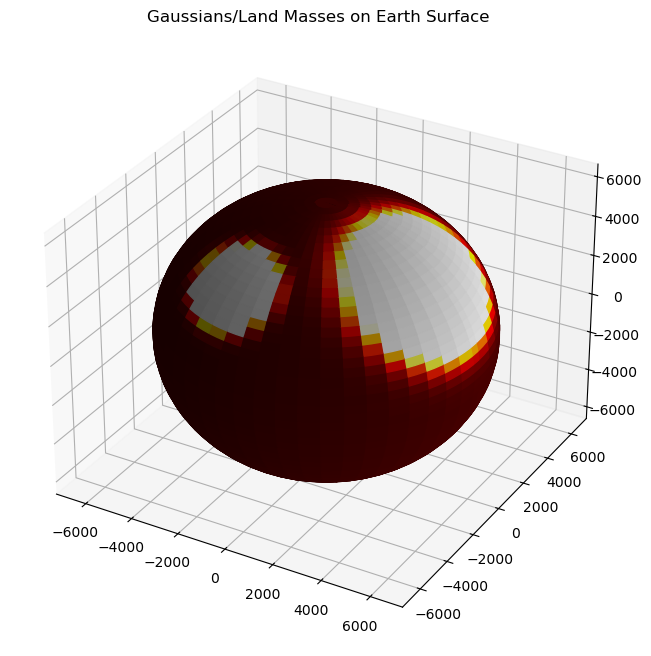

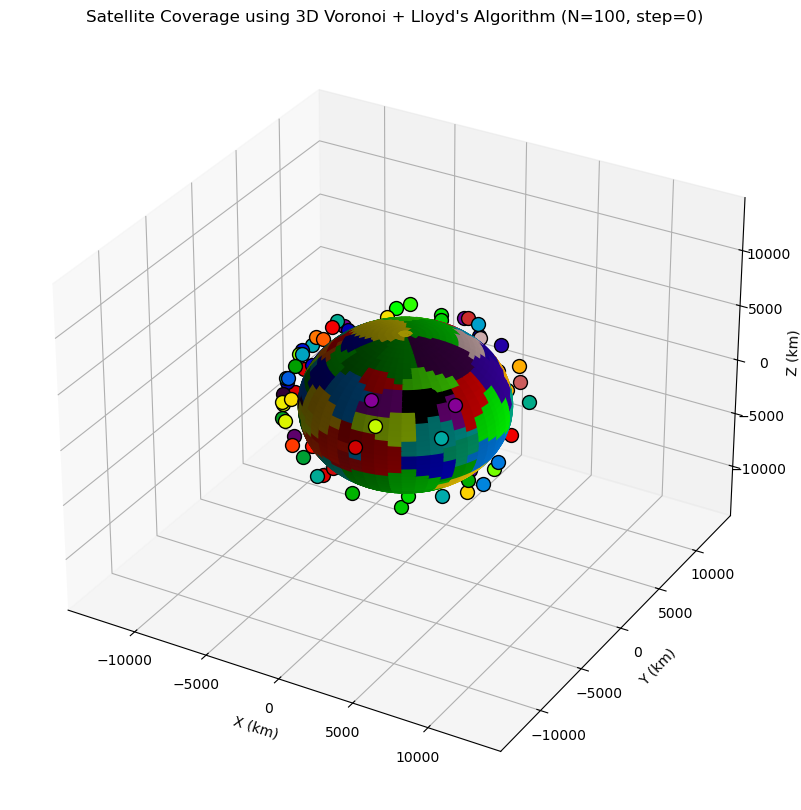

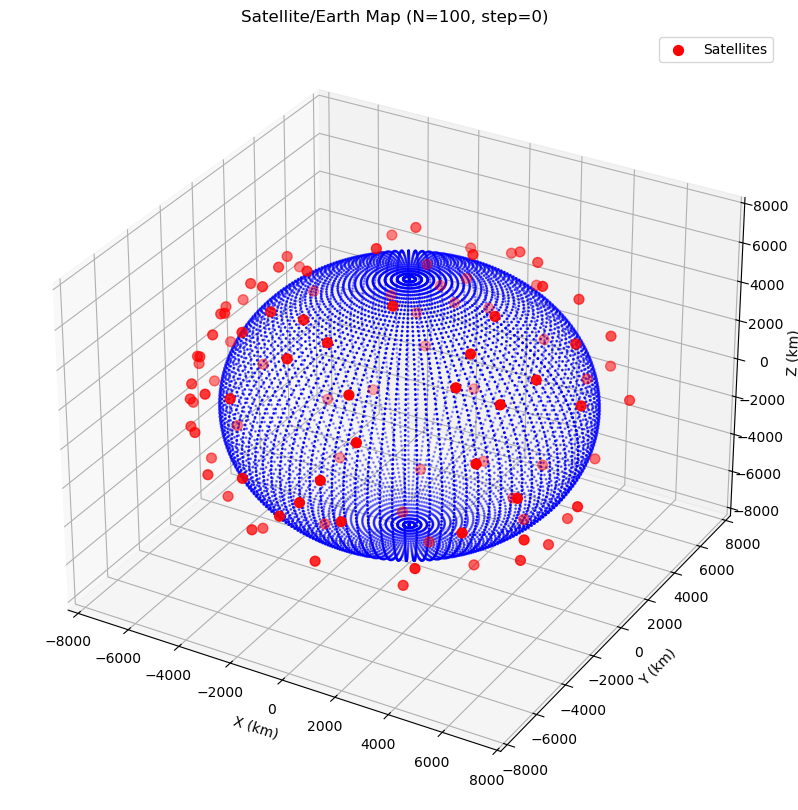

In [ ]:
update(N=100, alt=1000, tf=3600, dt=1, k=0.8, tol=1e-6)